In [7]:
!pip install scikit-learn numpy matplotlib pennylane --upgrade

Kullanılan Özellik Sayısı (Kübit): 2, Örnek Sayısı: 178

Kuantum Çekirdek Matrisi Hesaplanıyor...
-> İlerleme: 50/178 (Geçen Süre: 39.87 saniye)
-> İlerleme: 100/178 (Geçen Süre: 56.44 saniye)
-> İlerleme: 150/178 (Geçen Süre: 64.82 saniye)


--- KARŞILAŞTIRMA METRİKLERİ ---
| Metrik                          | Klasik PCA | Kuantum Kernel PCA |
|---------------------------------|------------|--------------------|
| Açıklanan Varyans (İlk 2 Bileşen) | 1.0000   | N/A (Çekirdek Uzayı)     |
| Siluet Skoru (0-1 Arası, Yüksek iyi)| 0.4351   | 0.5376         |
--------------------------------------------------------------------
Karar: Kuantum Kernel PCA, daha iyi küme yapısı oluşturdu (daha yüksek Siluet Skoru).

Sonuç: İki görseli karşılaştırarak Kuantum Çekirdek'in veriyi Klasik PCA'dan nasıl farklı bir geometride ayırdığını görebilirsiniz.


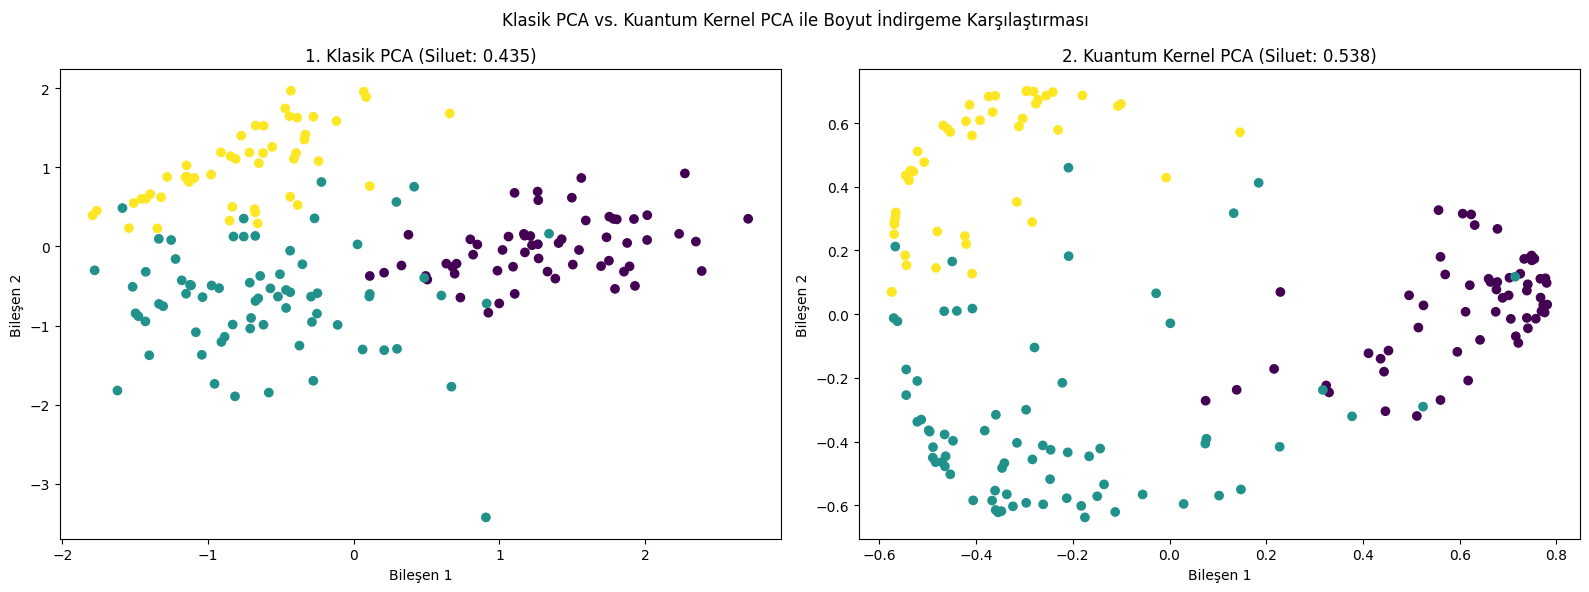

In [8]:

import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import silhouette_score # Siluet Skoru Eklendi!
import time


np.random.seed(42)
data = load_wine()
X = data.data
y = data.target

X_scaled = StandardScaler().fit_transform(X)
# Simülasyon hızını korumak için sadece 2 özellik kullanıyoruz.
X_q = X_scaled[:, [0, 6]]
n_qubits = X_q.shape[1]
n_components_target = 2
n_samples = len(X_q)

print(f"Kullanılan Özellik Sayısı (Kübit): {n_qubits}, Örnek Sayısı: {n_samples}")
print("===================================================================")



# A) Kuantum Devresi (Ansatz) Tanımlama
def feature_map(x):
    """Veri Kodlama ve Dolanıklık Katmanı."""
    qml.AngleEmbedding(x, wires=range(n_qubits), rotation='Y')
    for i in range(n_qubits):
        qml.CZ(wires=[i, (i + 1) % n_qubits])

# B) Kuantum Çekirdek Fonksiyonu (Overlap)
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="autograd")
def kernel_circuit(x1, x2):
    """İki veri noktası arasındaki örtüşmeyi ölçmek için devre."""
    feature_map(x1)
    qml.adjoint(feature_map)(x2) # Tersini/Eşleniğini uygula
    return qml.probs(wires=range(n_qubits))

def quantum_kernel_matrix(X_data):
    """Tüm X_data çiftleri için Kuantum Çekirdek Matrisi'ni hesaplar."""
    K = np.zeros((n_samples, n_samples))
    start_time = time.time()
    for i in range(n_samples):
        for j in range(i, n_samples):
            probs = kernel_circuit(X_data[i], X_data[j])
            K[i, j] = probs[0]
            K[j, i] = K[i, j]

        if (i + 1) % 50 == 0:
            elapsed = time.time() - start_time
            print(f"-> İlerleme: {i+1}/{n_samples} (Geçen Süre: {elapsed:.2f} saniye)")
    return K



# KLASİK PCA
pca_classical = PCA(n_components=n_components_target)
X_reduced_classical = pca_classical.fit_transform(X_q)
classical_variance_sum = np.sum(pca_classical.explained_variance_ratio_)

# KUANTUM KERNEL PCA
print("\nKuantum Çekirdek Matrisi Hesaplanıyor...")
try:
    kernel_matrix_quantum = quantum_kernel_matrix(X_q)

    kpca_quantum = KernelPCA(n_components=n_components_target, kernel="precomputed")
    X_reduced_quantum = kpca_quantum.fit_transform(kernel_matrix_quantum)
    quantum_ready = True

except Exception as e:
    print(f"Hata: PennyLane simülasyonunda sorun oluştu: {e}")
    quantum_ready = False
    X_reduced_quantum = np.zeros((len(X_q), n_components_target))




# 6.1. Klasik PCA Siluet Skoru
try:
    # Siluet Skoru, y etiketlerini kullanarak kümelerin ne kadar iyi ayrıldığını ölçer.
    sil_score_classical = silhouette_score(X_reduced_classical, y)
except:
    sil_score_classical = np.nan

# 6.2. Kuantum Kernel PCA Siluet Skoru
if quantum_ready:
    try:
        # Kuantum Kernel PCA'da, indirgenmiş vektörler üzerindeki ayrımı ölçeriz.
        sil_score_quantum = silhouette_score(X_reduced_quantum, y)
    except:
        sil_score_quantum = np.nan
else:
    sil_score_quantum = np.nan

print("\n\n--- KARŞILAŞTIRMA METRİKLERİ ---")
print("| Metrik                          | Klasik PCA | Kuantum Kernel PCA |")
print("|---------------------------------|------------|--------------------|")
print(f"| Açıklanan Varyans (İlk 2 Bileşen) | {classical_variance_sum:.4f}   | N/A (Çekirdek Uzayı)     |")
print(f"| Siluet Skoru (0-1 Arası, Yüksek iyi)| {sil_score_classical:.4f}   | {sil_score_quantum:.4f}         |")
print("--------------------------------------------------------------------")
if sil_score_quantum > sil_score_classical and quantum_ready:
    karar = 'Kuantum Kernel PCA, daha iyi küme yapısı oluşturdu (daha yüksek Siluet Skoru).'
elif sil_score_classical > sil_score_quantum and quantum_ready:
    karar = 'Klasik PCA, daha iyi küme yapısı oluşturdu (daha yüksek Siluet Skoru).'
else:
    karar = 'Nicel karşılaştırma, kuantum simülasyonu başarısız olduğu için yapılamadı.'

print(f"Karar: {karar}")




fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Klasik PCA Görselleştirmesi
ax1.scatter(X_reduced_classical[:, 0], X_reduced_classical[:, 1], c=y, cmap='viridis')
ax1.set_title(f'1. Klasik PCA (Siluet: {sil_score_classical:.3f})')
ax1.set_xlabel('Bileşen 1'), ax1.set_ylabel('Bileşen 2')

# 2. Kuantum Kernel PCA Görselleştirmesi
if quantum_ready:
    ax2.scatter(X_reduced_quantum[:, 0], X_reduced_quantum[:, 1], c=y, cmap='viridis')
    ax2.set_title(f'2. Kuantum Kernel PCA (Siluet: {sil_score_quantum:.3f})')
    ax2.set_xlabel('Bileşen 1'), ax2.set_ylabel('Bileşen 2')
    print("\nSonuç: İki görseli karşılaştırarak Kuantum Çekirdek'in veriyi Klasik PCA'dan nasıl farklı bir geometride ayırdığını görebilirsiniz.")
else:
    ax2.text(0.5, 0.5, "Kuantum Simülasyonu Başarısız Oldu.", ha='center', va='center', fontsize=12, color='red')
    ax2.set_title('2. Kuantum Kernel PCA (Simülasyon Hatalı)')


plt.suptitle('Klasik PCA vs. Kuantum Kernel PCA ile Boyut İndirgeme Karşılaştırması')
plt.tight_layout()
plt.show()